In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from hydromt_sfincs import SfincsModel
from matplotlib import animation

# %pip install ffmpeg

Load model.

In [2]:
# select the example model
model = "garissa_depth2m_srtm30_grid100"
sfincs_root = Path(fr"model/{model}")  # (relative) path to sfincs root
curr_dir = Path(os.getcwd())
model = SfincsModel(sfincs_root, mode="r")

Read results:

In [3]:
model.read_results()

print(model.results.keys())

dict_keys(['inp', 'msk', 'zb', 'zs', 'zsmax', 'total_runtime', 'average_dt'])


### Determining the maximum flood depth
This code is used to determine the maximum flood depth over the simulation.

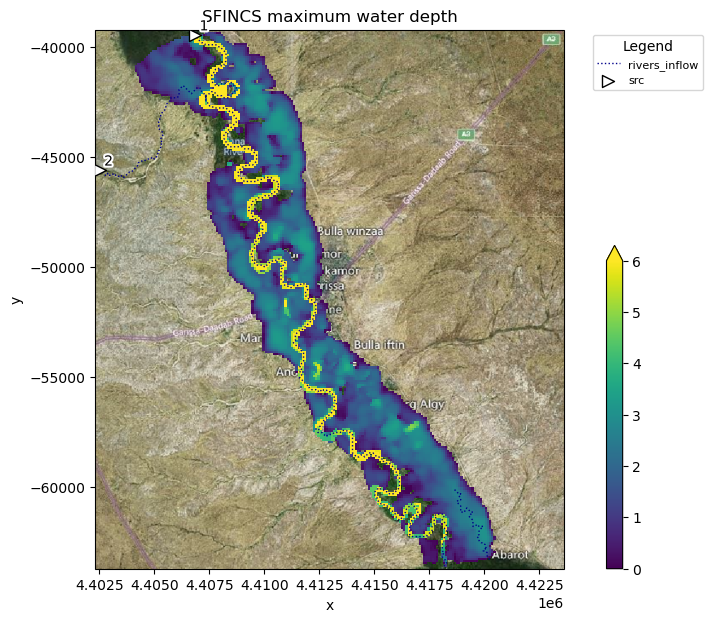

In [4]:
zs = model.results["zs"]
zsmax = zs.max(dim='time')
 
bed_level =  model.results["zb"].copy()
water_level_max = zsmax - bed_level
 
water_level_max
 
# hmax = utils.downscale_floodmap(
#     zsmax=water_level_max,
#     dep=dep, #Use subgrid
#     hmin=hmin,
#     # gdf_mask=gdf_osm,
#     # floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
# )
 
 
 
fig, ax = model.plot_basemap(
    fn_out=None,
    variable="", # no variable to plot, only basemap
    plot_bounds=False,
    bmap="sat",
    figsize=(11, 7),
    zoomlevel = 12
)
 
 
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = water_level_max.plot(
    x="x", y="y",
    ax=ax,
    vmin=0.0, vmax=6.0,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs,
)
 
ax.set_title(f"SFINCS maximum water depth")
#plt.savefig(join(scenario_dir, 'hmax.png'), dpi=225, bbox_inches="tight")
plt.show() 

### Creating an animation

This code is used to create animation of the depth.

In [5]:
plot_video = True   # This may take up to 20 minutes for a long video

In [6]:
zs = model.results["zs"]
zsmax = zs.max(dim='time')
 
bed_level =  model.results["zb"].copy()
water_level = model.results["zs"].copy()

depth = water_level - bed_level

# Create quick video
step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}

def update_plot(i, depth, cax_h):
    depth = depth.isel(time=i)
    t = depth.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(depth.values.ravel())

fig, ax = model.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(7, 7)
)
cax_h = depth.isel(time=0).plot(
    x="x", y="y", ax=ax, 
    vmin=0.0, vmax=6.0,
    cmap=plt.cm.viridis,
    alpha=0.75, cbar_kwargs=cbar_kwargs)

plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, depth.time.size, step),
    interval=100,  # ms between frames
    fargs=(depth, cax_h,),
)

# # to show in notebook:
from IPython.display import HTML

print("plotting video")
HTML(ani.to_html5_video())

# # Set up the writer
# writer = animation.FFMpegWriter(fps=10)  # Adjust fps as needed

# # Save the animation

# ani.save(curr_dir.joinpath(Path(f"videos/{model}.mp4")), writer=writer)

plotting video
